Setting up Parameter Estimation for WHONDRS Incubation Experiments

Dataset: S19S_0006_SED_INC-U (Respiration Incubuation Data)

Conceputal Model: Simple organic matter oxidation defined by the Lambda Formulation

Reaction Network:

Fitted Parameters: 
(2) $u_{max}$
(3) $V_h$, $O_2 / V_h$, $CH_2O$ (assume these are equal)
(4) $CC$

Species included:
$CH_2O$(aq) = general organic matter, assumed to be $CH_2O$ for stoich.
BIOMASS = general biomass($C_5H_7O_2N$).

TODO: ADD MORE DOC/EQN...


# Libraries

In [1]:
import ipywidgets as widgets
from IPython.display import display
import os
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import Layout, Box, Label, RadioButtons, Tab, HBox, VBox, Accordion, Select, interactive, Dropdown, interact
import subprocess, os, shutil, sys
import matplotlib
import math
import seaborn as sns
# import pflotran as pft

# File Locations

In [111]:
dir_code = '../src'
dir_data = '../data/WHONDRS/Incubation_Data'
dir_pflotran='../data/WHONDRS/Fit/pflotran_inout'
dir_reaction = '../data/WHONDRS'
dir_database ='../data/Database'
dir_fit_output = '../data/WHONDRS/Fit'

#dir_pflotran = './pflotran_inout'

# Create or clean up dir_pflotran
if os.path.isdir(dir_pflotran):
    # os.rmdir(dir_pflotran)
    shutil.rmtree(dir_pflotran)
    os.mkdir(dir_pflotran)
else:
    os.mkdir(dir_pflotran)
    

In [3]:
# Add the package to PYTHON path variable
import sys
sys.path.append(dir_code)
from DAPBRS.it import mi, mi_sst
from DAPBRS.pflotran import read_observed_ensemble_pflotran_output, write_parameter_h5
from DAPBRS.pflotran import run_pflotran, update_ensemble, plot_pflotran_pass_fail_runs
from DAPBRS.pflotran import pflotran_batch_reaction_WHONDRS_respiration_template_CH2O, generate_pflotran_database, run_pflotran, read_pflotran_output
from DAPBRS.da import es

%load_ext autoreload
%autoreload 2

In [103]:
%reload_ext autoreload

In [5]:
# Set numpy random seed so that the notebook is reproducible
np.random.seed(10)

# ESMDA Settings

In [6]:
n_ensemble = 50  #number of model simulation runs
n_assimilations = 5  # number of data assimilation
inflation = n_assimilations # inflation coefficients

# Observations

In [7]:
# Define the maximum observation time (unit: [min])
max_obs_time = 20

## Observation data

In [8]:
Incubation_Name = 'S19S_006_SED_INC-U'

In [9]:
df = pd.read_csv(os.path.join(dir_data, Incubation_Name+'.csv'))

In [10]:
# Get the Oxygen Data
obs_o2 = df['O2 [mg/L]']/1000/15.999
obs_o2.index = df['Time [min]']

# Substract the observations that are within the maximum time
obs_o2 = obs_o2[obs_o2.index<=max_obs_time]

obs_dict = {
    'Total O2(aq) [M]': obs_o2,
}

# All observed time steps
obs_timesteps = list(obs_o2.index)
obs_timesteps = list(set(obs_timesteps))
obs_timesteps.sort()


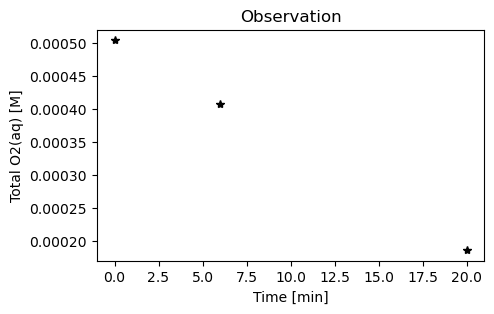

In [11]:
# Plot
for varn,obs in obs_dict.items():
    fig, ax = plt.subplots(1,1,figsize=(5,3))
    ax.plot(obs.index, obs.values, 'k*')
    ax.set(ylabel=varn, xlabel='Time [min]', title='Observation')
    

In [12]:
# # Convert all observations into an array
# obs_array = np.array([v for varn, values in obs_dict.items() for v in values.values ])
timesteps_str = ''
for i,t in enumerate(obs_timesteps):
    timesteps_str += str(t)+' '
    if ((i+1)%3==0) and ((i+1)!=len(obs_timesteps)):
        timesteps_str += '\ \n '


## Observation error

In [13]:
# Define relative observation error here
relative_obs_error = 0.05 # five percent

# Initial Conditions for the Simulation

In [14]:
# Current Setup for CH2O general. Refer to LambdaModel Batch Test Notebook to connect to Lambda Binning
primary_species_block = ['HCO3-','NH4+','HPO4--','HS-','H+','O2(aq)','BIOMASS','CH2O(aq)-DONOR']

In [15]:
# Input Initial Concentrations for Primary Species:
num_lambda_bins = 1
TotalCarbon = 2.16e-4
HCO3 = 7.20e-5
NH4 = 1.43e-4
HPO4 = 1e-20
HS = 1e-20
pH = 6.93
O2 = 5.04e-4
BIOMASS = 1e-5
    
aq_initial = [HCO3, NH4, HPO4, HS, 10**-pH, O2, BIOMASS, TotalCarbon]

# Generate the prior ensemble parameters

In [16]:
# Parameters To Estimate 
n_para = 3
logarithm = True
para_list = ['mu_max','Vh','CC']
para_units = ['1/min', 'm^3', 'M']  # Not linked to input deck at this time
para_low  = [1e-3, 1e-1, 1e-4]
para_high = [1e2, 1e2, 1e-2]

# Fixed Parameters
fixed_para_list = ['k_deg','NH4_inhibit']
fixed_para_units = ['1/min', 'M']   # Not linked to input deck at this time
fixed_para_values = [1e-20, 1e-20]
           
# log uniform distrubtion for the parameter ensemble
para_ens = []
for i in range(n_para):
    if logarithm:
        para = np.random.uniform(low=np.log10(para_low[i]), high=np.log10(para_high[i]), size=n_ensemble)
    else:
        para = np.random.uniform(low=para_low[i], high=para_high[i], size=n_ensemble)
    # para     = np.power(10, log_para)
    para_ens.append(para)
    # logm2 = np.random.uniform(low=np.log10(para_2_low), high=np.log10(para_2_high), size=n_ensemble)
para_ens = np.stack(para_ens, axis=1).T  # Prior ensemble
para_ens.shape


(3, 50)

In [17]:
# Write the ensemble data into HDF5 file
# See example: https://docs.h5py.org/en/stable/high/file.html
# f_ensemble_para = os.path.join(dir_data, 'parameter.h5')
f_ensemble_para = './parameter.h5'
write_parameter_h5(f_ensemble_para, para_list, para_ens, n_assimilations, logarithm)


Overwrite the file: ./parameter.h5
A new parameter ensemble h5 file is created at: ./parameter.h5


# Basecase PFLOTRAN Input Deck

In [106]:
f_input = 'ensemble_pflotran'
pflotran_in = os.path.join(dir_pflotran, f_input +".in")

# Folder Locations for database, rxn network, and dbase files
reaction_db=os.path.abspath(os.path.join(dir_database, 'hanford_rxn_network.dat'))
rxn_network_db=os.path.abspath(os.path.join(dir_reaction, 'reaction_network_CH2O.txt'))
dbase_file=os.path.abspath(f_ensemble_para)

# PFLOTRAN OUTPUT FILENAME FOR PLOTTING
f_out= "./{}-obs".format(f_input)
f_out_stderr = os.path.join(dir_pflotran, "{}.stdout".format(f_out))

str_aq_in, str_carbon_in = pflotran_batch_reaction_WHONDRS_respiration_template_CH2O(
        f_pflotranin=pflotran_in, 
        total_simulation_time=max_obs_time, 
        reaction_db=reaction_db,
        rxn_network_db=rxn_network_db,
        primary_species_db=primary_species_block,
        aq_initial = aq_initial,
        num_lambda_bins=num_lambda_bins,
        dbase_file=dbase_file,
        timesteps=timesteps_str, 
        mu_max=para_list[0], Vh=para_list[1], CC=para_list[2],
        k_deg = fixed_para_values[0], NH4_inhibit = fixed_para_values[1]
        )


# Perform Sensitivity Analysis

In [19]:
########################################### RUN Ensemble PFLOTRAN ####################################
run_pflotran(pflotran_in, n_ensemble, f_out_stderr)


Running 50 realizations of PFLOTRAN
Simulation completes!


In [20]:
########################################### Get the observed PFLOTRAN outputs ####################################
pflotran_ens_dict, obs_ens_dict, incomplete_runs = \
    read_observed_ensemble_pflotran_output(dir_pflotran, f_input, n_ensemble, obs_dict, max_obs_time)


Please regenerate the ensemble of the prior parameter with revised parameter ranges if too many unsuccessful PFLOTRAN runs!


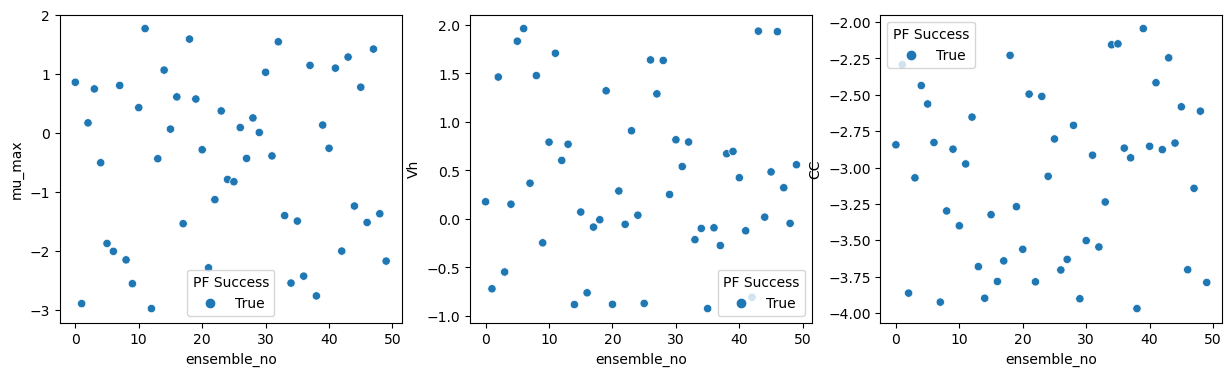

In [21]:
########################################### Plot the successful/unsuccessful runs ####################################
plot_pflotran_pass_fail_runs(para_list, para_ens, incomplete_runs)
    

In [22]:
########################################### (Optional) Remove the unsuccessful runs ####################################
# if there are unsuccessful runs and people want to continue, the following steps need to be done
# (1) revise the n_ensemble; (2) regenerate the 'parameter.h5'; 
# (3) update variable 'obs_ens_dict'; and (4) update the prior ensemble parameter variable 'para_ens'
n_ensemble, para_ens, obs_ens_dict = update_ensemble(
    incomplete_runs, f_ensemble_para, para_list, para_ens, obs_ens_dict, n_assimilations, logarithm)


Updating the parameter ensemble file with 50 successful realizaitons...
Overwrite the file: ./parameter.h5
A new parameter ensemble h5 file is created at: ./parameter.h5


In [23]:
########################################### Plot PFLOTRAN outputs ####################################
for varn,ens in obs_ens_dict.items():
    obs  = obs_dict[varn]
    print(obs)
    time = obs.index
    fig, ax = plt.subplots(1, 1, figsize=(5,3))
    #for i in range(n_ensemble):
    for i in range(ens.shape[1]):
        if i == 0:
            ax.plot(time, ens[:,i], 'grey', label='pflotran output')
        else:
            ax.plot(time, ens[:,i], 'grey')
    ax.plot(time, ens.mean(axis=1), 'red', label='pflotran output mean')
    ax.plot(time, obs.values, 'k*', label='observation')
    ax.set(xlabel='Time [min]', ylabel=varn)
    ax.legend()


Time [min]
0     0.000504
6     0.000407
20    0.000186
Name: O2 [mg/L], dtype: float64


In [24]:
########################################### Perform sensitivity analysis ####################################
nbins = 10 # number of bins used to discretize at each dimension for pdf computation
sensitivity = {}

for varn, state_ens in obs_ens_dict.items():
    n_time = state_ens.shape[0]
    s =np.zeros([n_para, n_time])
    # Perform sensitivity
    for t in range(n_time):
        for i in range(n_para):
            s[i,t] = mi(para_ens[i,:], state_ens[t,:], bins=nbins)  # with sst
            # s[i,t] = mi_sst(para_ens[i,:], state_ens[t,:], bins=nbins)  # with sst
    sensitivity[varn] = s


/scratch/katie/batch-reaction-pipeline/calibration/../src/DAPBRS/it.py:16: RuntimeWarning: divide by zero encountered in log
  log_pdf = ma.filled(np.log(ma.masked_equal(pdf, 0)), 0)


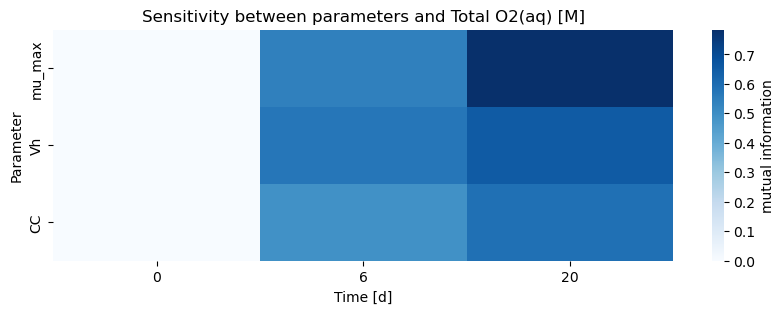

In [25]:
# Plot the result
for varn,s in sensitivity.items():
    times = list(obs_dict[varn].index)
    fig, ax = plt.subplots(1,1,figsize=(10,3))
    sns.heatmap(s, ax=ax, cmap='Blues', xticklabels=times, cbar_kws={'label': 'mutual information'})
    ax.set(yticklabels=para_list, xlabel='Time [d]', ylabel='Parameter', 
           title='Sensitivity between parameters and {}'.format(varn));


# Perform ESMDA

In [26]:
########################################### Perform data assimilation ####################################
prior_para_all = np.zeros([n_assimilations, n_para, n_ensemble])
post_para_all  = np.zeros([n_assimilations, n_para, n_ensemble])

prior_para_all[0,:,:] = para_ens

for i in range(n_assimilations):
    print('Perform the ESMDA at the {} iteration'.format(i+1))
    
    # Obtain the prior ensemble
    prior_para = prior_para_all[i,:,:]

    # Since the model simulation is done at sensitivity analysis, 
    # we don't do this at the first assimilation iteration
    if i != 0:  
        # Update the prior parameter file
        with h5py.File(f_ensemble_para,'r+') as f:
            for j,para in enumerate(para_list):
                d = f[para]
                if logarithm:
                    d[...] = np.power(10, prior_para[j,:])
                else:
                    d[...] = prior_para[j,:]

         ############################
        # Run ensemble forward model using prior parameters
        run_pflotran(pflotran_in, n_ensemble, f_out_stderr)
    
        # Obtain prior model states
        pflotran_ens_dict, obs_ens_dict, incomplete_runs = \
            read_observed_ensemble_pflotran_output(dir_pflotran, f_input, n_ensemble, obs_dict, max_obs_time)
        # obs_ens_dict, obs_in_pflotran_dict = \
        #     read_observed_ensemble_pflotran_output(dir_pflotran, f_input, n_ensemble, obs_dict)
    
    # Convert the format of model states and observations into array
    prior_state = np.vstack([obs_ens_dict[varn] for varn in obs_ens_dict.keys()])
    obs         = np.hstack([obs_dict[varn].values for varn in obs_ens_dict.keys()])
    
    # Generate the observation error
    obs_error = obs * relative_obs_error
    
    # Perform ES to compute the posterior parameters
    post_para = es(prior_para, prior_state, obs, obs_error, inflation)
    # if positive: 
    #     for j,para in enumerate(para_list):
    #         post_para[post_para<=0] = para_low[j]
    # # Make sure the parameters are within the lower and upper bounds
    for j,para in enumerate(para_list):
        if logarithm:
            post_para[j,post_para[j,:]<np.log10(para_low[j])] = np.log10(para_low[j])
            post_para[j,post_para[j,:]>np.log10(para_high[j])] = np.log10(para_high[j])
        else:
            post_para[j,post_para[j,:]<para_low[j]] = para_low[j]
            post_para[j,post_para[j,:]>para_high[j]] = para_high[j]
    post_para_all[i,:,:] = post_para
    
    # Update the prior parameters from the posterior parameters
    if i != n_assimilations-1: 
        prior_para_all[i+1,:,:] = post_para
    

Perform the ESMDA at the 1 iteration
Perform the ESMDA at the 2 iteration
Running 50 realizations of PFLOTRAN
Simulation completes!
Perform the ESMDA at the 3 iteration
Running 50 realizations of PFLOTRAN
Simulation completes!
Perform the ESMDA at the 4 iteration
Running 50 realizations of PFLOTRAN
Simulation completes!
Perform the ESMDA at the 5 iteration
Running 50 realizations of PFLOTRAN
Simulation completes!


In [27]:
# Write all prior and posterior data into the parameter h5 file
with h5py.File(f_ensemble_para,'r+') as f:
    for j,para in enumerate(para_list):
        dir_prior          = f["{}_prior".format(para)]
        dir_post           = f["{}_posterior".format(para)]
        if logarithm:
            dir_prior[...]     = np.power(10, prior_para_all[:,j,:])
            dir_post[...]      = np.power(10, post_para_all[:,j,:])
        else:
            dir_prior[...]     = prior_para_all[:,j,:]
            dir_post[...]      = post_para_all[:,j,:]


# Plot the updated ensemble parameter

In [28]:
# Assemble ensemble parameter
perm_df = pd.DataFrame(columns=["value","para", "prior_or_post", "iteration"])

for i in range(n_assimilations):
    for j,para in enumerate(para_list): 
        perm_df_prior = pd.DataFrame(
            np.array([prior_para_all[i,j,:],[para]*n_ensemble,["prior"]*n_ensemble,[i+1]*n_ensemble]).T, 
            columns=["value","para", "prior_or_post", "iteration"]
        )
        perm_df_post = pd.DataFrame(
            np.array([post_para_all[i,j,:],[para]*n_ensemble,["post"]*n_ensemble,[i+1]*n_ensemble]).T, 
            columns=["value","para", "prior_or_post", "iteration"]
        )
        perm_df = perm_df.append(perm_df_prior)
        perm_df = perm_df.append(perm_df_post)
perm_df = perm_df.astype({"value":float,"para":str,"prior_or_post":str, "iteration":int})


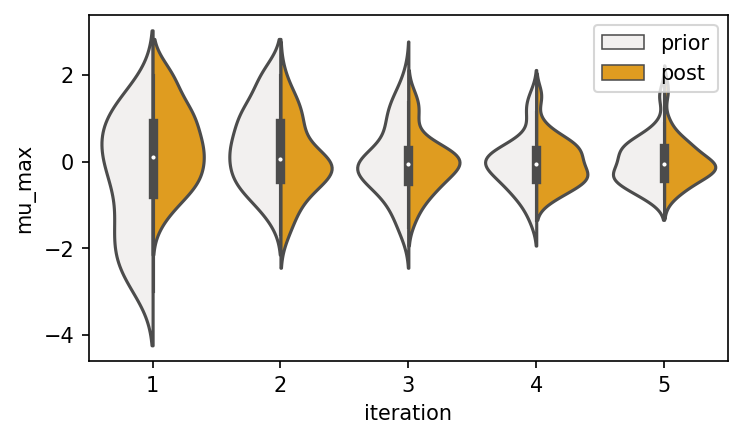

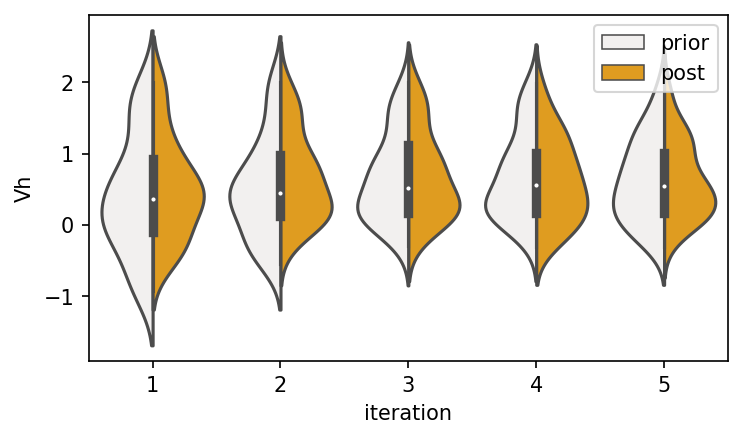

In [29]:
# Plot
for j,para in enumerate(para_list):
    _, ax = plt.subplots(1, 1, figsize=(5.5,3), dpi=150)
    ax = sns.violinplot(x="iteration", y="value",hue='prior_or_post',split=True,
                        color="orange",data=perm_df[perm_df["para"]==para],scale='width')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right')
    ax.set(ylabel=para, xlabel='iteration')


# Plot the calibrated PFLOTRAN output

In [30]:
########################################### Run PFLOTRAN again #################################### 
# Update the prior parameter file
with h5py.File(f_ensemble_para,'r+') as f:
    for j,para in enumerate(para_list):
        d = f[para]
        if logarithm:
            d[...] = np.power(10,post_para[j,:])
        else:
            d[...] = post_para[j,:]

# Run ensemble forward model using prior parameters
run_pflotran(pflotran_in, n_ensemble, f_out_stderr)

# Obtain prior model states
pflotran_ens_dict, obs_ens_dict, incomplete_runs = \
            read_observed_ensemble_pflotran_output(dir_pflotran, f_input, n_ensemble, obs_dict, max_obs_time)


Running 50 realizations of PFLOTRAN
Simulation completes!


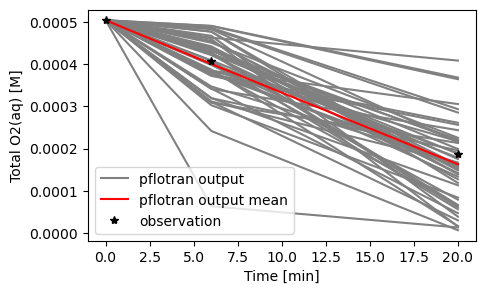

In [31]:
########################################### Plot PFLOTRAN outputs ####################################
for varn,ens in obs_ens_dict.items():
    obs  = obs_dict[varn]
    time = obs.index
    fig, ax = plt.subplots(1, 1, figsize=(5,3))
    for i in range(n_ensemble):
        if i == 0:
            ax.plot(time, ens[:,i], 'grey', label='pflotran output')
        else:
            ax.plot(time, ens[:,i], 'grey')
    ax.plot(time, ens.mean(axis=1), 'red', label='pflotran output mean')
    ax.plot(time, obs.values, 'k*', label='observation')
    ax.set(xlabel='Time [min]', ylabel=varn)
    ax.legend()


In [94]:
parameters = os.path.join('parameter.h5')
f1 = h5py.File(parameters,'r')


In [95]:
parm_est_2 = []
parm_avg = []
parm_std = []
for i in range(1,len(list(f1.keys())),3):
    parm_est = list(f1.keys())[i]
    parm_est_2.append(parm_est)
parm_est_2.reverse()

for item in parm_est_2:
    avg = np.mean(f1[item][-1,:])
    std = np.std(f1[item][-1,:])
    parm_avg.append(avg)
    parm_std.append(std)

In [ ]:
# Forward Simulation with Mean Parameters

# Statistical Output of Fit

In [36]:
# SSE
# R^2
# NSE
# AICc


# Calculate Respiration Rate

In [37]:
#Resp_Rate = # Compute Bulk Rate or at each model output time to see temporal changes?


# Create Output File for Fitting

In [112]:
list_out = []
par_estimations = []
output = []
for ii in range(2, len(f1.keys()),3):
    list_parm = list(f1.keys())[ii]
    list_out.append(list_parm)
    parm_est = f1[list_parm]
    #parm_value = parm_est[-1,-1]
    par_estimations.append(parm_value)
for i in range(len(para_list)):
    headers = ['fitted parameter', 'specified lower bound', 'specified upper bound', 'fitted value (avg)', 'fitted value (stdev)']
    val_out = [para_list[i], para_low[i], para_high[i], parm_avg[i], parm_std[i], para_units[i]]
    output.append(val_out)

val_out_2 = "".join("{}\n    ".format(v) for i, v in enumerate(output))

In [114]:
fit_summary = os.path.join(dir_fit_output, Incubation_Name+'_fit.txt')
with open(fit_summary,'w') as f:
    f.write('Dataset: '+ Incubation_Name)
    f.writelines(['\n','\n', 'Data used in fitting:', '\n', str(df)])
    f.writelines(['\n','\n', 'Initial Conditions [M]:', '\n', str_aq_in, str_carbon_in])
    f.writelines(['\n','\n', 'ESMDA Settings:', '\n', 'number of model simulation runs:', str(n_ensemble), '\n', 'number of data assimilation:', str(n_assimilations)])
    f.writelines(['\n','\n', 'Fitted Parameters:', '\n',str(headers),'\n', str(val_out_2), '\n'])
    
    f.writelines(['\n' 'Non-Fitted Parameters:', '\n',str(fixed_para_list[0])+ ': ',str(fixed_para_values[0]) + ' ', str(fixed_para_units[0]),'\n', \
                  str(fixed_para_list[1])+ ': ', str(fixed_para_values[1]) + '  ', str(fixed_para_units[1]), '\n'])
    # Add Computed Stats
    